In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.plotting import bootstrap_plot

In [2]:
# Connect to data base
import mysql.connector as mysql
from mysql.connector import Error
try:
    db = mysql.connect(
        host = "localhost",
        database='mestradoNOTA',
        user = "root",
        passwd = "admin123"
    )
    
    if db.is_connected():
        cursor = db.cursor(buffered=True)
#         cursor = db.cursor()
except Error as e:
    print("Error while connecting to MySQL", e)


## Evolução das notas

In [165]:
where1 = " and isquotaholder = 'NAO' AND (CONVERT(semester_year, UNSIGNED INTEGER) > 20041 AND CONVERT(semester_year, UNSIGNED INTEGER) < 20121)"
where1Cotista = " and isquotaholder = 'SIM' AND (CONVERT(semester_year, UNSIGNED INTEGER) > 20041 AND CONVERT(semester_year, UNSIGNED INTEGER) < 20121)"

# where1 = " and isquotaholder = 'NAO' AND (CONVERT(semester_year, UNSIGNED INTEGER) >= 20121 AND CONVERT(semester_year, UNSIGNED INTEGER) < 20161)"
# where1Cotista = " and isquotaholder = 'SIM' AND (CONVERT(semester_year, UNSIGNED INTEGER) >= 20121 AND CONVERT(semester_year, UNSIGNED INTEGER) < 20161)"

# where1 = " and isquotaholder = 'NAO' AND CONVERT(semester_year, UNSIGNED INTEGER) >= 20161"
# where1Cotista = " and isquotaholder = 'SIM' AND CONVERT(semester_year, UNSIGNED INTEGER) >= 20161"


whereClause = " (name = 'ALGORITMOS E PROGRAMACAO DE COMPUTADORES' OR name = 'COMPUTACAO BASICA' OR name = 'INTRODUCAO A CIENCIA DA COMPUTACAO')"

In [173]:
select_query = "select semester_year, AVG(num_score) as média from students as st inner join student_course_subject as SCS on st.id = SCS.id_student INNER JOIN subjects as S ON S.id = SCS.id_subject where" + whereClause + where1 + " group by semester_year order by semester_year"
cursor.execute(select_query)
records = pd.DataFrame(cursor.fetchall())
records.columns = cursor.column_names
records = records[records['semester_year'] != '20080']

avg = pd.to_numeric(records['média'])
semester_year = records['semester_year'].apply(str).tolist()
new_list = ["{}-{}".format(x[0:-1],x[-1]) for x in semester_year]

select_query_cotista = "select semester_year, AVG(num_score) as média from students as st inner join student_course_subject as SCS on st.id = SCS.id_student INNER JOIN subjects as S ON S.id = SCS.id_subject where" + whereClause + where1Cotista + " group by semester_year order by semester_year"
cursor.execute(select_query_cotista)
records_cotista = pd.DataFrame(cursor.fetchall())
records_cotista.columns = cursor.column_names

avg_cotista = pd.to_numeric(records_cotista['média'])
semester_year_cotista = records_cotista['semester_year'].apply(str).tolist()
new_list_cotista = ["{}-{}".format(x[0:-1],x[-1]) for x in semester_year_cotista]


plotdata = pd.DataFrame({
    "média":avg.to_numpy(),
    "média cotista":avg_cotista.to_numpy()
    }, 
    index=new_list
)

Text(0, 0.5, 'nota dos alunos')

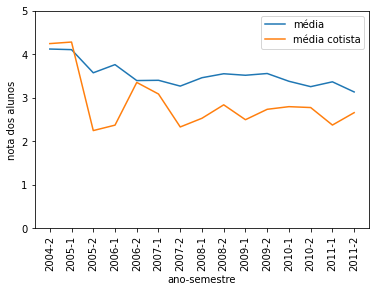

In [174]:
ax = plotdata.plot(ylim=[0, 5])
plt.xticks(np.arange(len(plotdata.index)), plotdata.index)
plt.xticks(rotation=90)
ax.set_xlabel("ano-semestre")
ax.set_ylabel("nota dos alunos")

## Evolução da quantidade de alunos aprovados comparando com total

In [131]:
select_query = "select semester_year, count(*) as total, SUM(CASE WHEN num_score > 2 THEN 1 ELSE 0 END) as Aprovado from students as st inner join student_course_subject as SCS on st.id = SCS.id_student INNER JOIN subjects as S ON S.id = SCS.id_subject where" + whereClause + where1 + " group by semester_year order by semester_year;"
cursor.execute(select_query)
records = pd.DataFrame(cursor.fetchall())
records.columns = cursor.column_names

total = records['total']
passou = pd.to_numeric(records['Aprovado'])
semester_year = records['semester_year'].tolist()
new_list = ["{}-{}".format(x[0:-1],x[-1]) for x in semester_year]

plotdata = pd.DataFrame({
    "Total":total.to_numpy(),
    "Aprovado":passou.to_numpy()
    }, 
    index=new_list
)

Text(0, 0.5, 'quantidade de alunos')

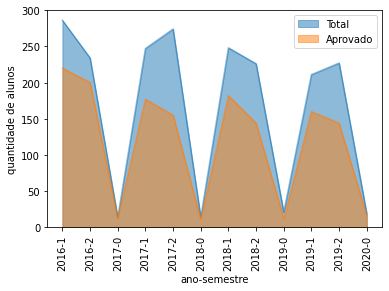

In [133]:
ax = plotdata.plot.area(stacked=False);
plt.xticks(np.arange(len(plotdata.index)), plotdata.index)
plt.xticks(rotation=90)
ax.set_xlabel("ano-semestre")
ax.set_ylabel("quantidade de alunos")

## Métricas das notas

In [134]:
select_query = "select num_score as nota from students as st inner join student_course_subject as SCS on st.id = SCS.id_student INNER JOIN subjects as S ON S.id = SCS.id_subject where" + whereClause + where1
cursor.execute(select_query)
records = pd.DataFrame(cursor.fetchall())
records.columns = cursor.column_names


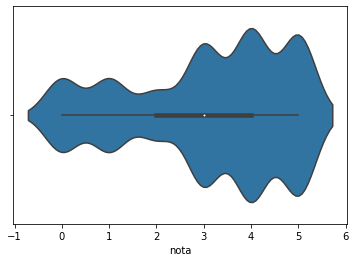

In [136]:
ax = sns.violinplot(x="nota", data=records)
ax.set_xlabel("nota")
plt.show()

## Quantidade de créditos comparando com o número de aprovações

In [138]:
select_query = "select semester_year, AVG(total_credits_semester) as total_credits_semester, AVG(approved_total_credits_semester) as approved_total_credits_semester, AVG(num_score) as num_score from students as st inner join student_course_subject as SCS on st.id = SCS.id_student INNER JOIN subjects as S on S.id = SCS.id_subject  where " + whereClause + where1 + " group by semester_year order by semester_year"
cursor.execute(select_query)
records = pd.DataFrame(cursor.fetchall())
records.columns = cursor.column_names

records['semester_year'] = ["{}-{}".format(x[0:-1],x[-1]) for x in records['semester_year']]


plotdata = pd.DataFrame({
    "total creditos no semestre":pd.to_numeric(records['total_credits_semester']).to_numpy(),
    "total creditos aprovados no semestre":pd.to_numeric(records['approved_total_credits_semester']).to_numpy(),
    "score":pd.to_numeric(records['num_score']).to_numpy()
    }, 
    index=records['semester_year'].tolist()
)



(0.0, 5.0)

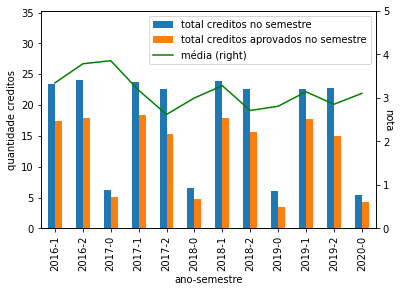

In [139]:
axes = plotdata[["total creditos no semestre", "total creditos aprovados no semestre"]].plot(kind="bar", rot=90, ylabel="quantidade creditos", xlabel="ano-semestre")
y_min, y_max = axes.get_ylim()
plotdata["score"].plot(secondary_y=True, style="g", legend=True, rot=90, ylim=(0, y_max+10), label="média");
plt.ylabel('nota', rotation=270)
plt.ylim([0,5])

In [140]:
## Comparativo dos alunos que fizeram pela primeira vez o curso com os alunos que fazem novamente.

In [141]:
select_query = "select id_student, semester_year, total_credits_semester, approved_total_credits_semester, num_score from students as st inner join student_course_subject as SCS on st.id = SCS.id_student INNER JOIN subjects as S on S.id = SCS.id_subject  where " + whereClause + where1 + " order by id_student, semester_year"
cursor.execute(select_query)
records = pd.DataFrame(cursor.fetchall())
records.columns = cursor.column_names

firstTime = pd.DataFrame(columns = cursor.column_names)
nextTime = pd.DataFrame(columns = cursor.column_names)
id_student = records['id_student'].unique().tolist()

count = 0
for i in id_student:
    firstTime.loc[count] = records[records['id_student']==i].iloc[0]
    count = count + 1;

for i in id_student:
    nextTime= pd.concat([nextTime, records[records['id_student']==i][1:]])


In [142]:
del firstTime["id_student"]
firstTime['total creditos no semestre'] = pd.to_numeric(firstTime['total_credits_semester'])
firstTime['total creditos aprovados no semestre'] = pd.to_numeric(firstTime['approved_total_credits_semester'])
firstTime['nota'] = pd.to_numeric(firstTime['num_score'])
firstTime['vez'] = 1

del nextTime["id_student"]
nextTime['total creditos no semestre'] = pd.to_numeric(nextTime['total_credits_semester'])
nextTime['total creditos aprovados no semestre'] = pd.to_numeric(nextTime['approved_total_credits_semester'])
nextTime['nota'] = pd.to_numeric(nextTime['num_score'])
nextTime['vez'] = 2

In [143]:
firstTimeGroup = firstTime.groupby(['semester_year']).mean()
nextTimeGroup = nextTime.groupby(['semester_year']).mean()

firstTimeGroupStd = firstTime.groupby(['semester_year']).std()
nextTimeGroupStd = nextTime.groupby(['semester_year']).std()
join = pd.concat([firstTime, nextTime])

In [144]:
semester_year = records['semester_year'].unique().tolist()
newValue = ["{}-{}".format(x[0:-1],x[-1]) for x in semester_year]
simpleList = []
for i in semester_year:
    total_primeira_vez = firstTime[firstTime['semester_year'] == i]['semester_year'].count()
    total_mais_uma_vez = nextTime[nextTime['semester_year'] == i]['semester_year'].count()
    try:
        media_primeira_vez = firstTimeGroup.loc[i]['nota']
        std_primeira_vez = firstTimeGroupStd.loc[i]['nota']
    except:
        media_primeira_vez = 0
        std_primeira_vez = 0
    try:
        media_mais_uma_vez = nextTimeGroup.loc[i]['nota']
        std_mais_uma_vez = nextTimeGroupStd.loc[i]['nota']
        
    except:
        media_mais_uma_vez = 0
        std_mais_uma_vez = 0
        
    simpleList.append([total_primeira_vez/len(semester_year), total_mais_uma_vez/len(semester_year), media_primeira_vez, media_mais_uma_vez, std_primeira_vez, std_mais_uma_vez])

plotdata = pd.DataFrame(simpleList,
                        columns=['total primeira vez', 'total mais uma vez', 'media primeira vez', 'media mais uma vez', 'std_primeira_vez', 'std_mais_uma_vez'],
                        index = newValue)
plotdata = plotdata.sort_index()

(0.0, 5.0)

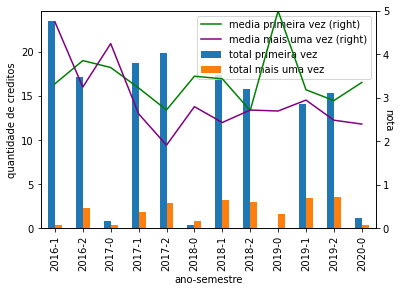

In [145]:
ax = plotdata[["media primeira vez", "media mais uma vez"]].plot(secondary_y=True, rot=90, style=['green','purple'], xlabel="ano-semestre", ylabel="quantidade de creditos")
axes = plotdata[["total primeira vez", "total mais uma vez"]].plot(kind="bar", rot=90, ax = ax)
plt.ylabel('nota', rotation=270)
plt.ylim([0,5])